# Initial Data Analysis
## General
### Topic

The objective of this research is to analyze performance metrics of different ML algorithms in the field of heart disease prediction using limited sample sizes and how they are influenced by varying training and validation strategies.

### Questions

1. How will the training and validation strategy of an ML algorithm impact the performance metrics?

    **Methods:** Randomly select stratified samples for varying sizes from the total data, determining the performance metrics and to average them afterwards. This process should be varied as follows:
    - Differ concrete algorithm: SVM, Bayes, KNN, Random Forest, Decision Tree, Logistic Regression.
    - Change number of selected features and feature selection methods: RFE and Sequential Feature Selection (eventually PCA, UMAP...).
    - Selecting Nested CV, K-Fold CV, Mixed CV or Train/Test Split for training/validation (feature selection, parameter tuning).
    - Changing the train-test-ratio in Train/Test Split, the number of folds in parameter selection in all validation methods and changing the number of folds in validation and feature selection in all methods apart from Train/Test Split.
2. How do performance metrics compare to one another when sample size varies?

    **Methods:** Change sample size and performance metric, do the training and in the end validate a given ML model on the test set. Performance metrics chosen: 'accuracy', 'balanced_accuracy', 'top_k_accuracy', 'average_precision', 'neg_brier_score' (more details at [Metrics and scoring](https://scikit-learn.org/stable/modules/model_evaluation.html))

3. How do subgroup structures impact performance metrics?

    **Methods:** Reduce samples to a certain group. Groups chosen: sex (male or female), age groups (young: age under 50, middle: 50 =< age < 65, elder: age >= 65). A combination of groups is also considered.

## Dataset

### Source

I am planning to use the [Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) by the UCI Center for Machine Learning and Intelligent Systems. It consists of four single datasets from the 1980s that have been published by the
1.	Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2.	University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3.	University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4.	V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

In the following I will mainly analyse the combined dataset, albeit commenting on the structure of the single datasets whenever relevant.

### Loading the Dataset

Before we describe our data, we need to load the data.

In [ ]:
import os
from math import ceil
import numpy as np
import pandas as pd
import jupyter
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, top_k_accuracy_score, average_precision_score, \
    brier_score_loss
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from statistics import mean, median
from scipy import stats
from matplotlib.colors import LogNorm

In [183]:
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope',
                    'ca', 'thal', 'target']
data_path = os.path.join(os.getcwd(), "data/")

# cleveland -- 0, hungarian -- 1, switzerland -- 2, va -- 3
cleveland_data = pd.read_csv(os.path.join(data_path, "processed.cleveland.data"), names=column_names)
cleveland_data['location'] = 0

hungarian_data = pd.read_csv(os.path.join(data_path, "processed.hungarian.data"), names=column_names)
hungarian_data['location'] = 1

switzerland_data = pd.read_csv(os.path.join(data_path, "processed.switzerland.data"), names=column_names)
switzerland_data['location'] = 2

va_data = pd.read_csv(os.path.join(data_path, "processed.va.data"), names=column_names)
va_data['location'] = 3

data = pd.concat([cleveland_data, hungarian_data, switzerland_data, va_data], axis=0, ignore_index=True)
data = data[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope',
                    'ca', 'thal', 'location', 'target']]

In [184]:
# this is some preprocessing
data['thal'].replace({'3.0': '0.0', '6.0': '1.0', '7.0': '2.0'}, inplace=True)

# In the raw data the '?' symbol is used for missing data. Let us replace those values by np.NaN.
data.replace('?', np.NaN, inplace= True)
data = data.astype({'age': int, 'sex': int, 'cp': int, 'trestbps': float, 'chol': float, 'fbs': float, 'restecg': float, 'thalach': float, 'exang': float, 'oldpeak': float, 'slope': float, 'ca': float, 'thal': float, 'location': int, 'target': int})

### Overview

Let us quickly inspect the data.

In [186]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,location,target
0,63,1,1,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,1.0,0,0
1,67,1,4,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,0.0,0,2
2,67,1,4,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,2.0,0,1
3,37,1,3,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,0.0,0,0
4,41,0,2,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,0,4,127.0,333.0,1.0,1.0,154.0,0.0,0.0,NaN,NaN,NaN,3,1
916,62,1,1,NaN,139.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3,0
917,55,1,4,122.0,223.0,1.0,1.0,100.0,0.0,0.0,NaN,NaN,6.0,3,2
918,58,1,4,NaN,385.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3,0


#### Columns

The datasets share the same 14 columns:

1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST
                    elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy
                    by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: A blood disorder called thalassemia (0 = normal; 1 = fixed defect; 2 = reversable defect)
14. target: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1, 2, 3, 4: > 50% diameter narrowing
15. location: location of origin (cleveland = 0, hungarian = 1, switzerland = 2, va = 3)

Only 'chol', 'thalach' and 'oldpeak' are continuous, whereas the other features are multiclass/binary. 'Thal' was adjusted from values in (3,6,7) to (0,1,2).

#### Samples

In total our data set consists of 920 samples. The most data comes from the cleveland and hungarian data set.

In [187]:
data.groupby(['location']).size()

location
0    303
1    294
2    123
3    200
dtype: int64

### Initial Plotting

Before discussing the actual missing values, we would like to do some plotting in advance to spot other defects in the data.

<Figure size 720x720 with 0 Axes>

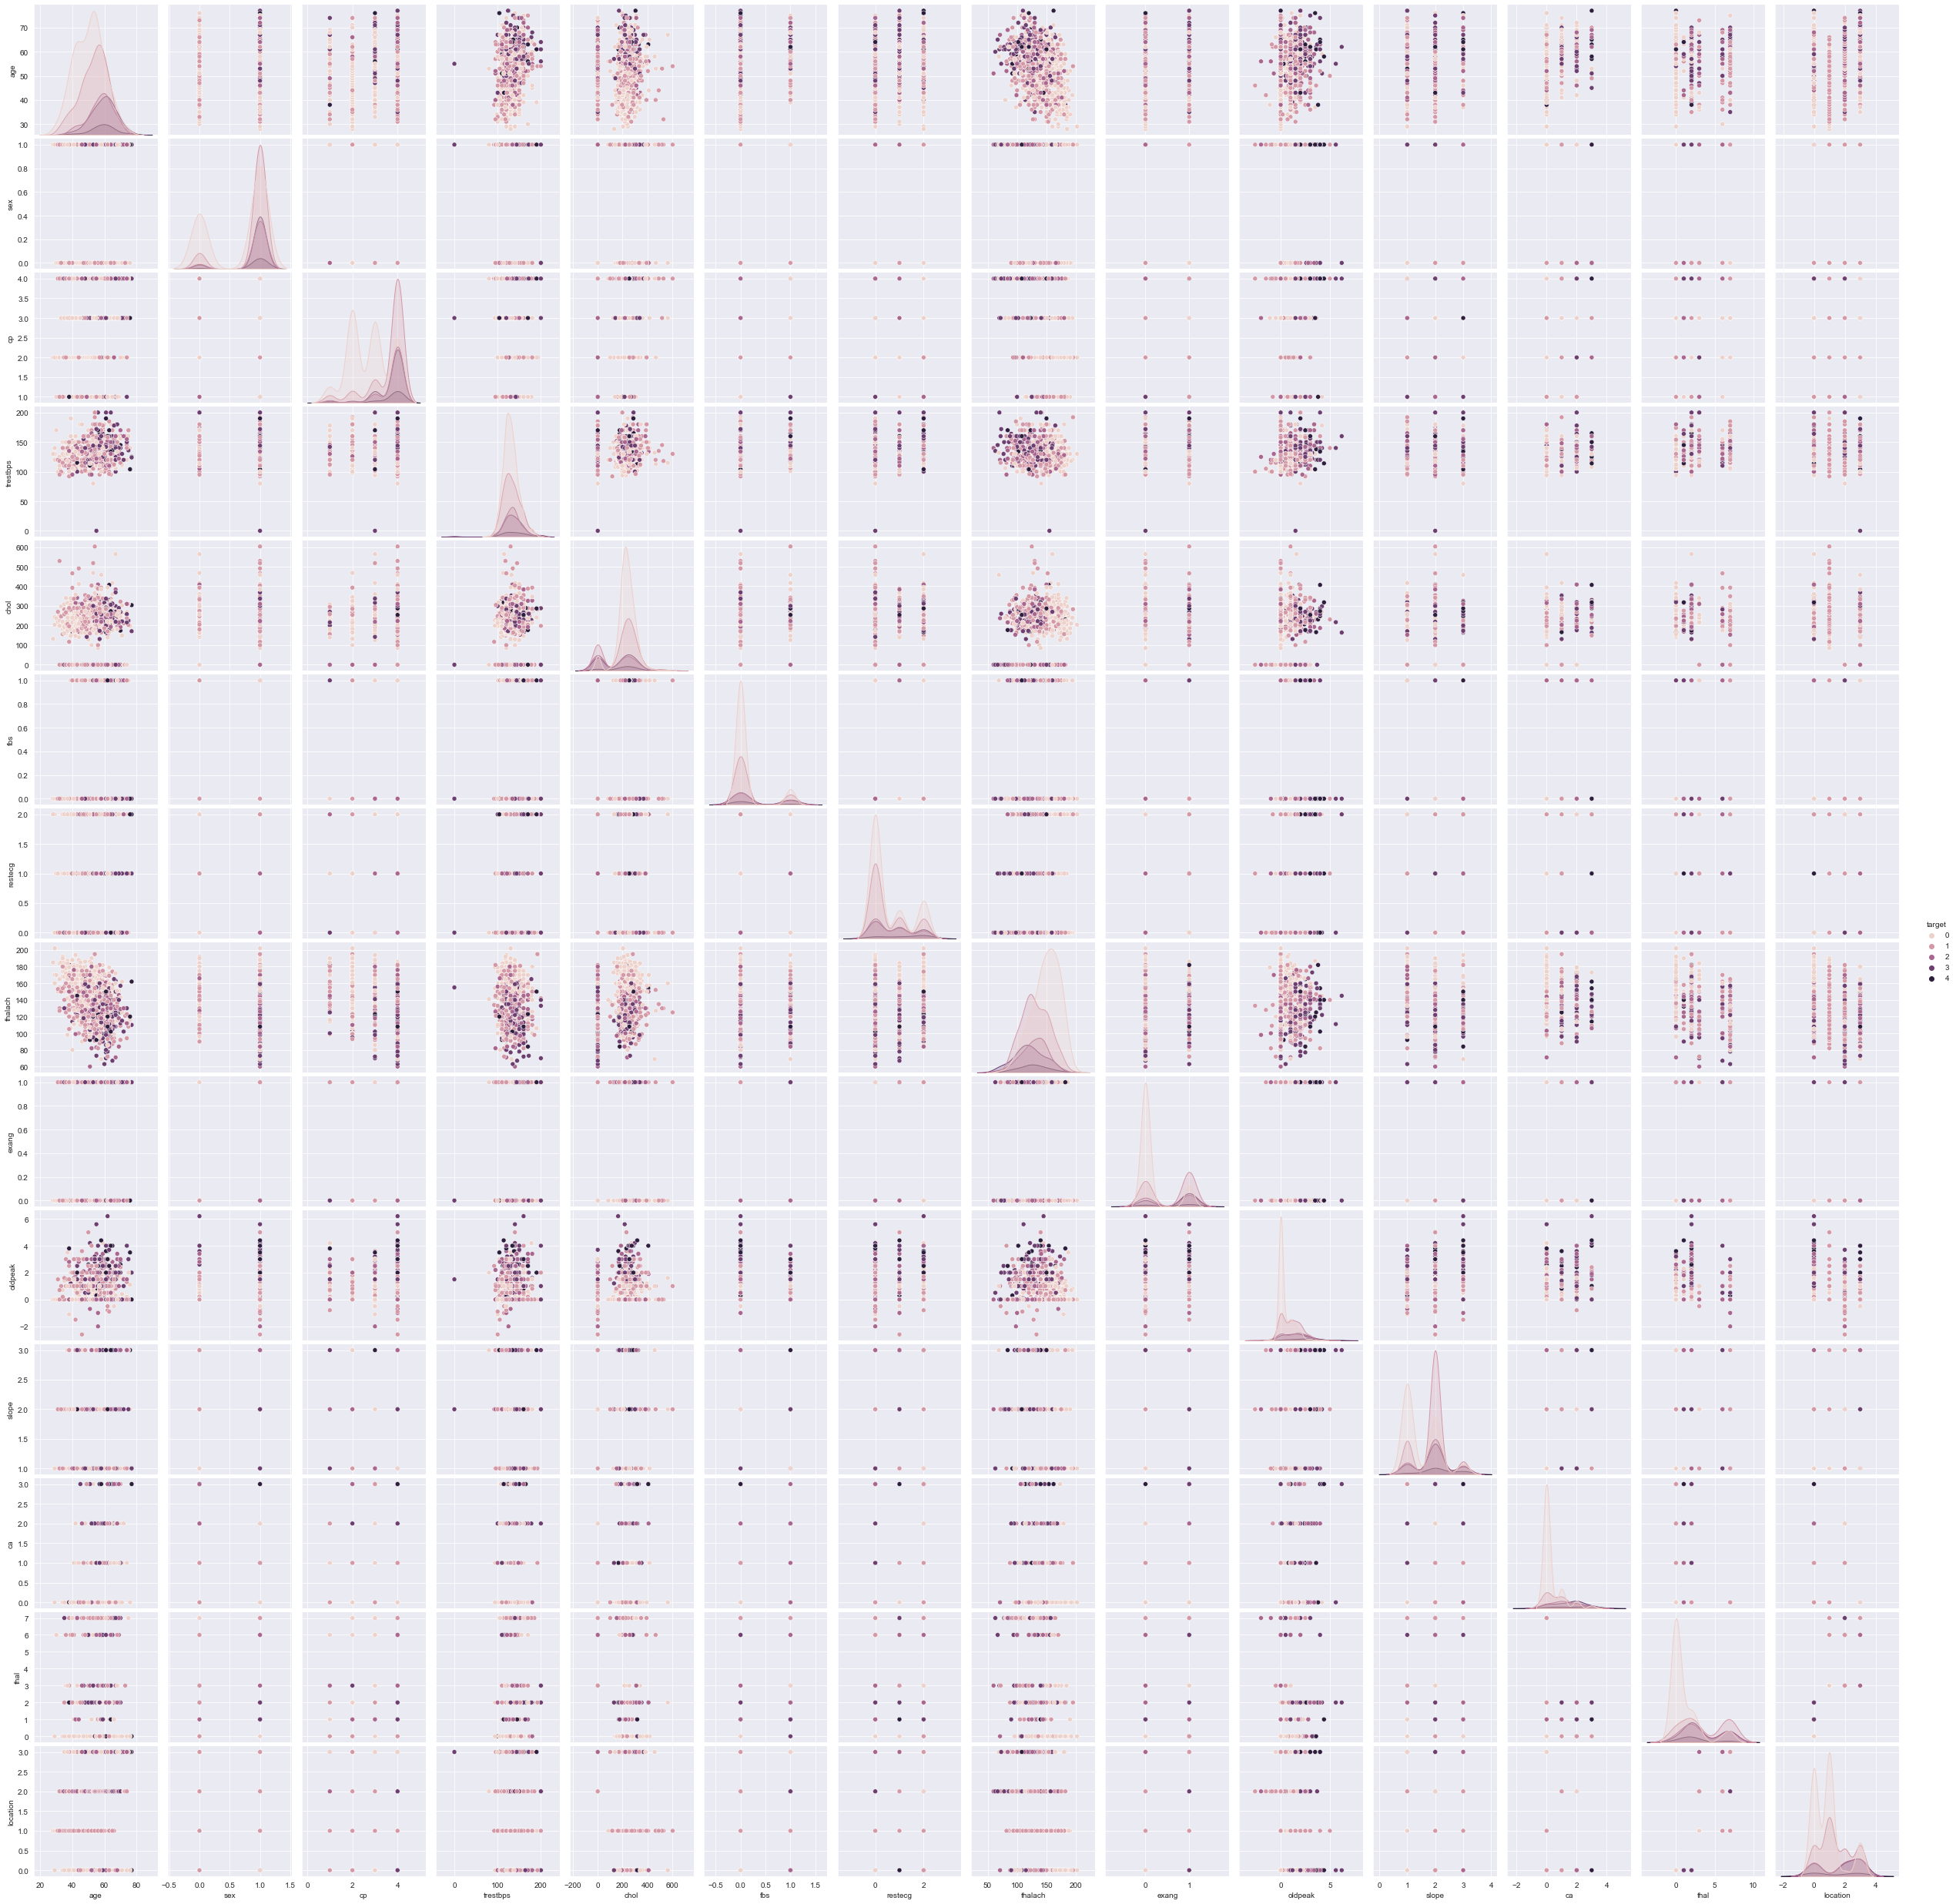

In [195]:
plt.figure(figsize=(10,10))
sns.pairplot(data, hue="target")
plt.show()

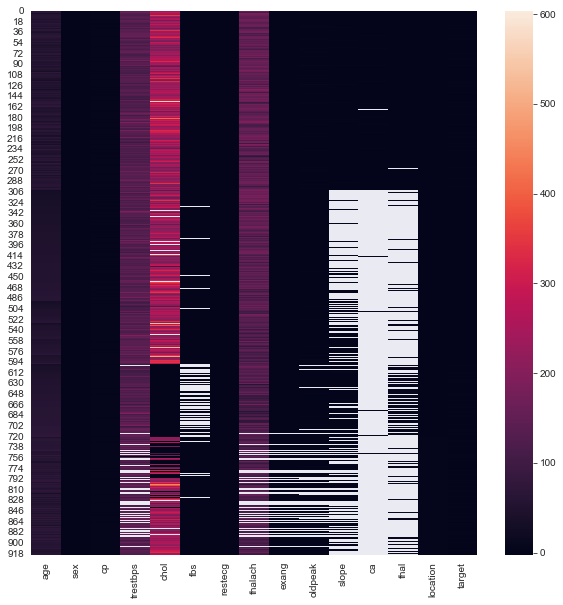

In [194]:
plt.figure(figsize=(10,10))
sns.heatmap(data)
plt.show()

One can see in the first plot that there are 0-values in the columns 'chol' and 'trestbps'. Thus we will consider those values in the following as missing values. One can see in the second plot that there are considerable missing values in the columns 'slope', 'ca' and 'thal' which will also be discussed in the following.

### Missing values
Let us check how many columns are affected by missing values.

In [256]:
# data[(data.isna()).any(1) | (data['chol'] == 0) | (data['trestbps'] == 0)]
#
# data.isna().sum() / len(data) * 100
# (data['chol'] == 0)

data.apply(lambda x: ((x.isna().sum() if (x.name != 'chol' and x.name != 'trestbps') else (x.isna() | x.apply(lambda y: y == 0)).sum()) / len(x) * 100))

age          0.000000
sex          0.000000
cp           0.000000
trestbps     6.521739
chol        21.956522
fbs          9.782609
restecg      0.217391
thalach      5.978261
exang        5.978261
oldpeak      6.739130
slope       33.586957
ca          66.413043
thal        52.826087
location     0.000000
target       0.000000
dtype: float64

In [236]:
data.isna().sum() / len(data) * 100

age          0.000000
sex          0.000000
cp           0.000000
trestbps     6.413043
chol         3.260870
fbs          9.782609
restecg      0.217391
thalach      5.978261
exang        5.978261
oldpeak      6.739130
slope       33.586957
ca          66.413043
thal        52.826087
location     0.000000
target       0.000000
dtype: float64

One can see that especially 'ca' and 'thal' have many missing values with an absence rate of over 66% and 52% respectively. Let us check the different data sets individually.

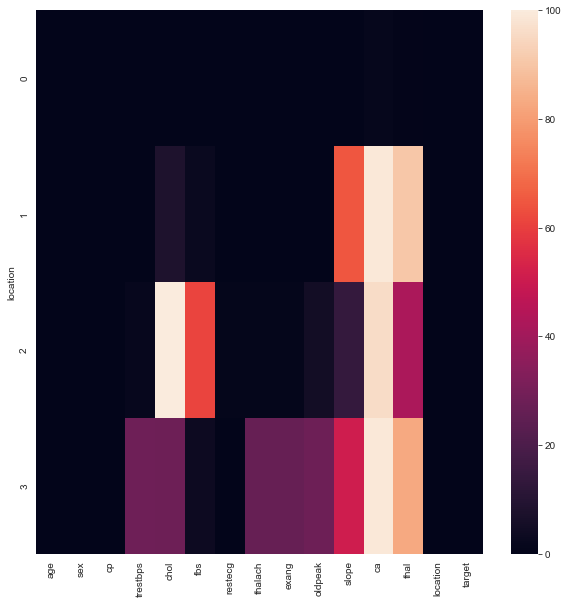

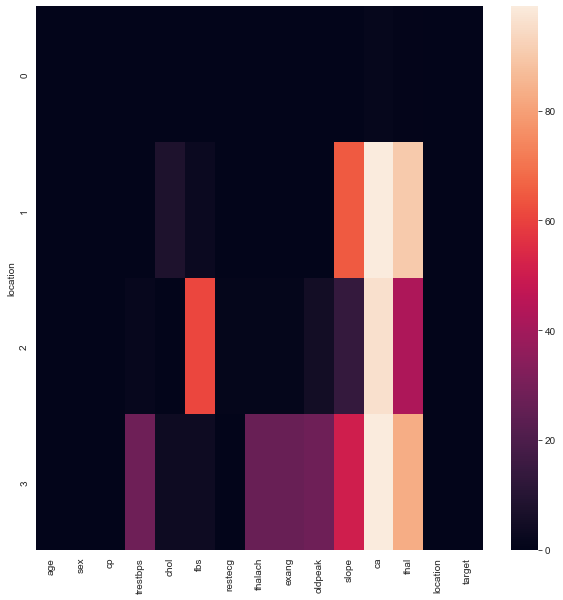

In [260]:
# all_data[all_data['location'] == 0].isna().sum() / len(all_data[all_data['location'] == 1]) * 100
missing = data.groupby('location').apply(lambda x: x.isna().sum() / len(x) *100)

# all_data[all_data['location'] == 0].isna().sum() / len(all_data[all_data['location'] == 1]) * 100
missing2 = data.groupby('location').apply(lambda x: x.apply(lambda y: ((y.isna().sum() if (y.name != 'chol' and y.name != 'trestbps') else (y.isna() | y.apply(lambda z: z == 0)).sum()) / len(y) * 100)))

plt.figure(figsize=(10, 10))
sns.heatmap(data=missing2)
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(data=missing)
plt.show()

In [250]:
missing

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,location,target
location,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.320132,0.660066,0.0,0.0
1,0.0,0.0,0.0,0.340136,7.823129,2.721088,0.340136,0.340136,0.340136,0.000000,64.625850,98.979592,90.476190,0.0,0.0
2,0.0,0.0,0.0,1.626016,0.000000,60.975610,0.813008,0.813008,0.813008,4.878049,13.821138,95.934959,42.276423,0.0,0.0
3,0.0,0.0,0.0,28.000000,3.500000,3.500000,0.000000,26.500000,26.500000,28.000000,51.000000,99.000000,83.000000,0.0,0.0


In [251]:
missing2

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,location,target
location,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.320132,0.660066,0.0,0.0
1,0.0,0.0,0.0,0.340136,7.823129,2.721088,0.340136,0.340136,0.340136,0.000000,64.625850,98.979592,90.476190,0.0,0.0
2,0.0,0.0,0.0,1.626016,0.000000,60.975610,0.813008,0.813008,0.813008,4.878049,13.821138,95.934959,42.276423,0.0,0.0
3,0.0,0.0,0.0,28.000000,3.500000,3.500000,0.000000,26.500000,26.500000,28.000000,51.000000,99.000000,83.000000,0.0,0.0


One can easily see, that the datasets of hungary, switzerland and va contribute to a high absence of 'ca' and 'thal'. The hungarian data set and the one from va also have a high absence of the 'slope' feature, 64% and 51% respectively. The switzerland data set has a 60% absence of the 'fbs' feature.

#### Solutions

There are multiple options to deal with missing values. One is to remove all rows, which have a NaN value in any column. But this will only leave us with

In [190]:
non_nan_data = data.dropna()
non_nan_data.groupby('location').size()

location
0    297
1      1
3      1
dtype: int64

While this might be a safe option it will drastically reduce our samples to mainly ones from the cleveland data set. Thus, imputation might be the way to go. While imputation could be done by using the mean oder median, the most plausible option would be to use knn imputation as it retains relative positions of samples.

In [191]:
imputer = KNNImputer(n_neighbors=5)
all_data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
all_data_imputed

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,location,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,1.0,0.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,0.0,0.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,2.0,0.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,0.0,0.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54.0,0.0,4.0,127.0,333.0,1.0,1.0,154.0,0.0,0.0,1.2,0.4,1.4,3.0,1.0
916,62.0,1.0,1.0,132.8,139.0,0.0,1.0,118.0,0.4,0.4,2.0,1.0,3.6,3.0,0.0
917,55.0,1.0,4.0,122.0,223.0,1.0,1.0,100.0,0.0,0.0,1.8,0.2,6.0,3.0,2.0
918,58.0,1.0,4.0,138.8,385.0,1.0,2.0,123.6,0.4,0.6,2.0,1.0,4.6,3.0,0.0
